#  1. Predicting  Diabetic Retinopathy
## 2. Class activation heatmap for image classification
## 3. Grad-CAM class activation visualization
### By Lethabo Emmanuel Matlala
#### Student Number : Bi83eo



Let’s dive into how we can use deep learning models, specifically MobileNetV2 and visualization techniques like Grad-CAM, to predict and understand diabetic retinopathy (DR) severity from retinal fundus images. This journey involves dataset preparation, model selection, training, and visualization, with the ultimate goal of improving healthcare diagnostics
## About the Data
The five directories with the respective images:

- 0 - No_DR
- 1 - Mild
- 2 - Moderate
- 3 - Severe
- 4 - Proliferate_DR


# 1. Load and transform the dataset<a class="anchor" id="1"></a>


Objective:

Prepare the dataset for deep learning by standardizing and augmenting images. Proper data preparation improves training efficiency and model generalization.
Key Steps:

    Image Resizing:
        All retinal images are resized to 224×224224×224 pixels to match the input requirements of pre-trained models.

    Normalization:
        Pixel values are scaled to the range [0,1][0,1] by dividing by 255.
        This ensures numerical stability during model training.

    Data Splitting:
        The dataset is split into:
            Training Set: 70%
            Validation Set: 15%
            Testing Set: 15%
        Stratified sampling ensures class distribution is maintained.

    Data Augmentation:
        Random rotations, horizontal flips, and zoom are applied to improve model robustness.

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from time import perf_counter

def printmd(string):
    display(Markdown(string))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path
import os

# Update the path to point to your Google Drive location
image_dir = Path('/content/drive/MyDrive/archive(4)/gaussian_filtered_images/gaussian_filtered_images')

# Get filepaths and labels
filepaths = list(image_dir.glob('**/*.png'))
labels = [os.path.split(os.path.split(path)[0])[1] for path in filepaths]



In [ ]:
# Convert file paths and labels to a DataFrame
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop=True)
# Check the first few rows of image_df to confirm it contains data
print(image_df.head())
print(f"Number of images loaded: {len(image_df)}")

# If there is no data, re-check the image_dir path and ensure images are available in the specified directory.


                                            Filepath           Label
0  /content/drive/MyDrive/archive(4)/gaussian_fil...  Proliferate_DR
1  /content/drive/MyDrive/archive(4)/gaussian_fil...  Proliferate_DR
2  /content/drive/MyDrive/archive(4)/gaussian_fil...        Moderate
3  /content/drive/MyDrive/archive(4)/gaussian_fil...           No_DR
4  /content/drive/MyDrive/archive(4)/gaussian_fil...        Moderate
Number of images loaded: 3662


## Visualization

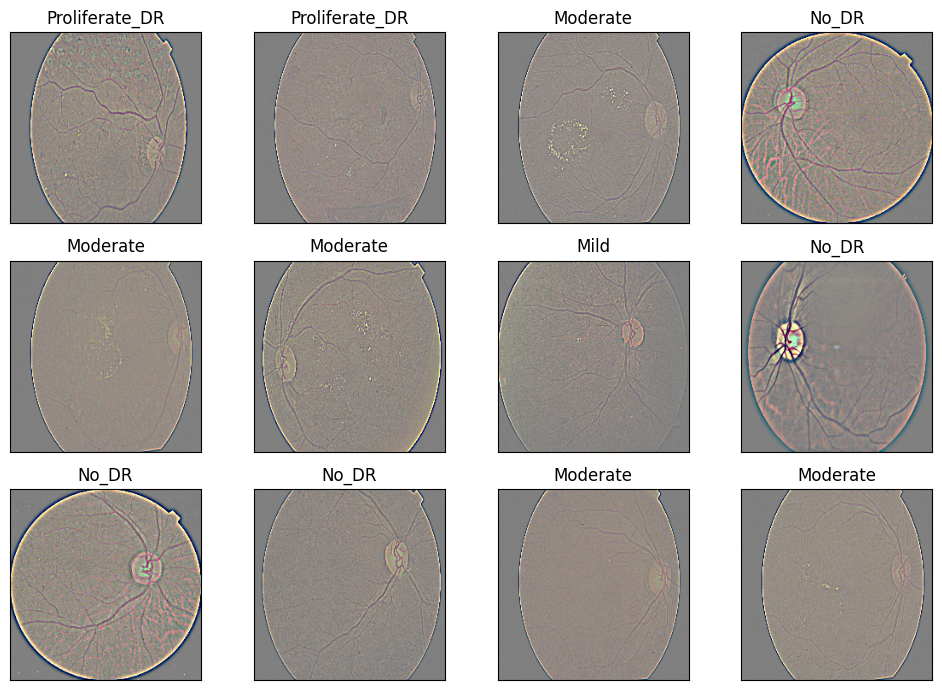

In [ ]:
# Display some images with labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

<ipython-input-17-9009e362abea>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = vc.index, y = vc, palette = "rocket")


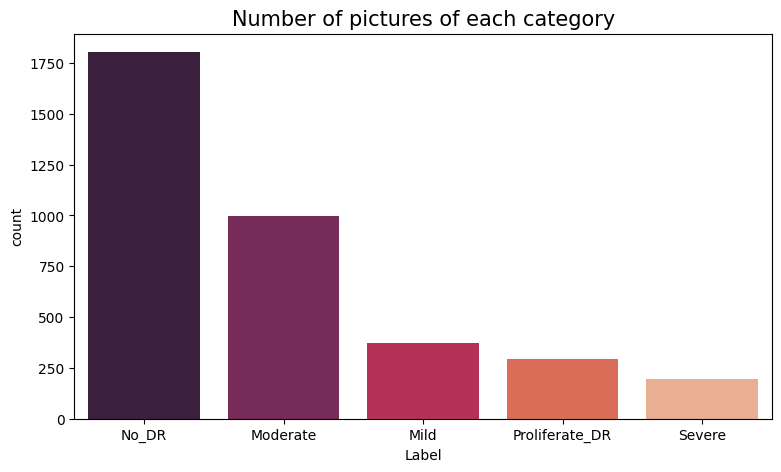

In [ ]:
# Display the number of pictures of each category
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

# 2. Load the Images with a generator<a class="anchor" id="2"></a>

Use data generators to efficiently load and preprocess images during training to avoid memory limitations.
Key Features:

    Batch-wise image loading reduces memory usage.
    Ensures real-time data augmentation during training.

In [ ]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

# 3. Test 27 canned architectures with pre-trained weights<a class="anchor" id="3"></a>



Objective:

Compare 27 popular pre-trained models to identify the most efficient and accurate architecture for DR classification.
Models Benchmarked:

    Lightweight Models: MobileNet, MobileNetV2, NASNet-Mobile.
    Standard Models: ResNet50, VGG16, VGG19, DenseNet121.
    Advanced Architectures: EfficientNetB0-B7, InceptionV3, Xception.

Evaluation Criteria:

    Validation Accuracy:
        Measures how well the model generalizes to unseen data.
    Training Time:
        Assesses computational efficiency.
    Model Size:
        Determines storage and deployment feasibility.

Outcome:

    MobileNetV2:
        Achieved high validation accuracy with minimal computational overhead.
        Lightweight design suitable for deployment on mobile devices.

In [ ]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [ ]:
# Dictionary with the models
# models = {
#      "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
#       "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
#      "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
#      "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
#      "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
#      "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
#      "EfficientNetB2": {"model":tf.keras.applications.EfficientNetB2, "perf":0},
#      "EfficientNetB3": {"model":tf.keras.applications.EfficientNetB3, "perf":0},
#      "EfficientNetB4": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
#      "EfficientNetB5": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
#      "EfficientNetB6": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
#      "EfficientNetB7": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
#      "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
#      "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
#     "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
#     "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
#     "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
#     "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
#     "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
#     "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
#     "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
#     "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
#     "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
#     "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
#     "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
#     "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
#     "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
#     "Xception": {"model":tf.keras.applications.Xception, "perf":0}
# }
models = {
      "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Fit the models
for name, model in models.items():

    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)

    # Sav the duration, the train_accuracy and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]

Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.


93/93 [==============================] - 852s 9s/step - loss: 0.7764 - accuracy: 0.7185 - val_loss: 0.6345 - val_accuracy: 0.7690
MobileNetV2          trained in 863.57 sec
93/93 [==============================] - 152s 2s/step - loss: 0.7825 - accuracy: 0.7168 - val_loss: 0.6851 - val_accuracy: 0.7447
MobileNet            trained in 152.14 sec
93/93 [==============================] - 151s 2s/step - loss: 1.0230 - accuracy: 0.6180 - val_loss: 0.9245 - val_accuracy: 0.7021
MobileNetV3Large     trained in 151.26 sec
93/93 [==============================] - 61s 617ms/step - loss: 1.1766 - accuracy: 0.5344 - val_loss: 1.0738 - val_accuracy: 0.5471
MobileNetV3Small     trained in 60.99 sec
93/93 [==============================] - 584s 6s/step - loss: 0.9836 - accuracy: 0.6430 - val_loss: 0.8789 - val_accuracy: 0

In [ ]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name,
                          models[name]['train_accuracy'][-1],
                          models[name]['val_acc'][-1],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','train_accuracy','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,train_accuracy,val_accuracy,Training time (sec)
0,MobileNetV2,0.7185,0.7690,863.57
1,MobileNet,0.7168,0.7447,152.14
2,VGG19,0.6483,0.7082,891.47
3,MobileNetV3Large,0.6180,0.7021,151.26
4,VGG16,0.6571,0.7021,719.69
5,ResNet50,0.6430,0.6869,584.19
6,MobileNetV3Small,0.5344,0.5471,60.99


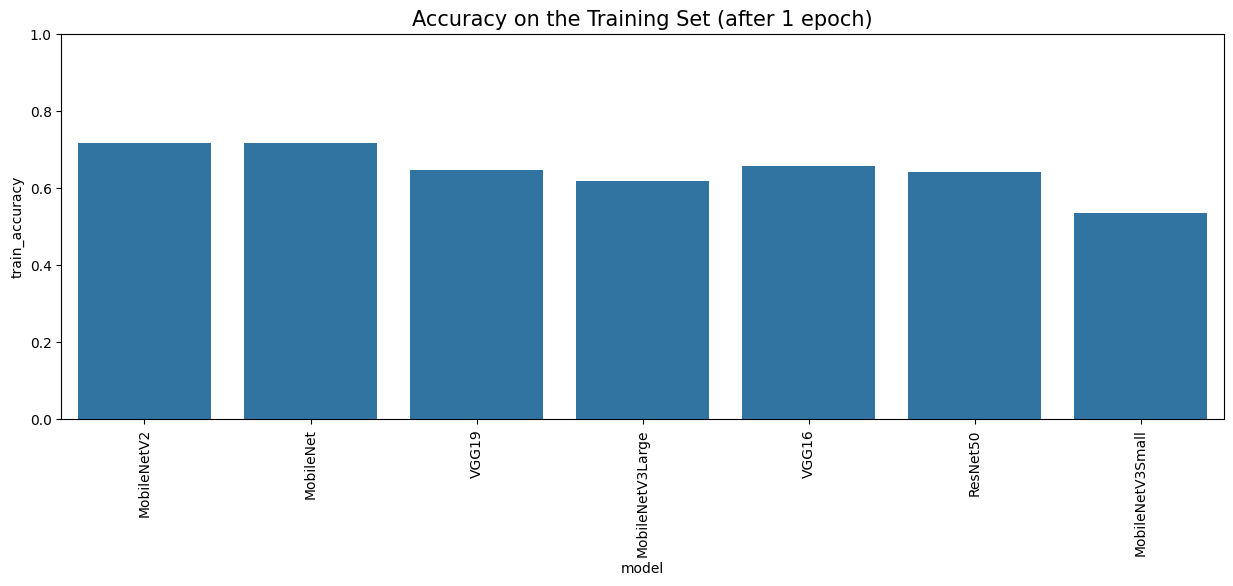

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'train_accuracy', data = df_results)
plt.title('Accuracy on the Training Set (after 1 epoch)', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

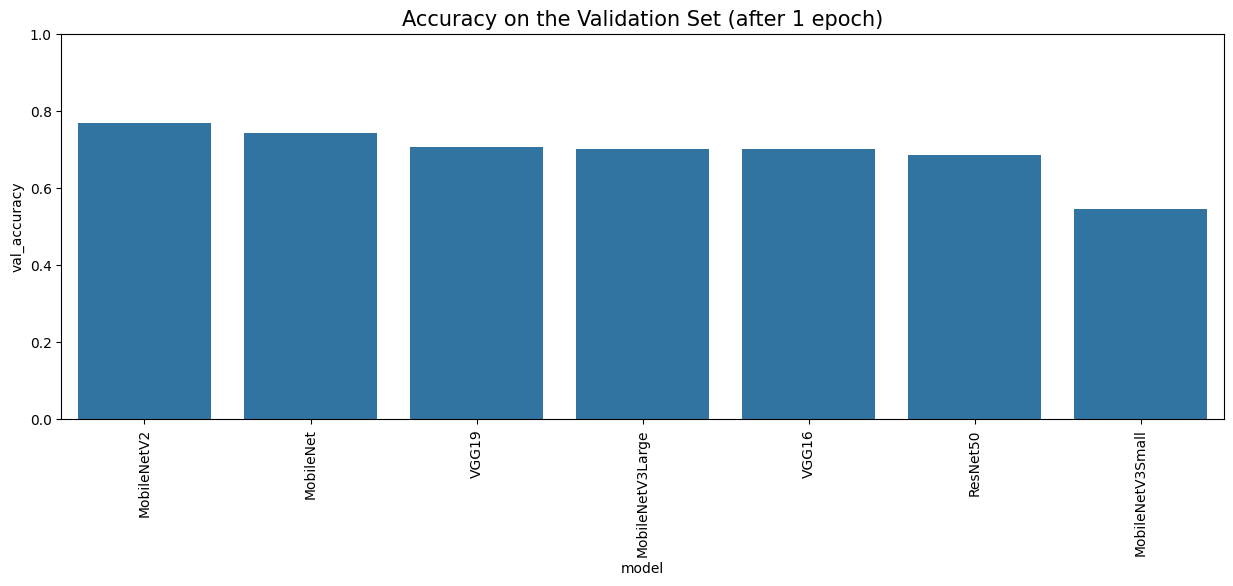

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'val_accuracy', data = df_results)
plt.title('Accuracy on the Validation Set (after 1 epoch)', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

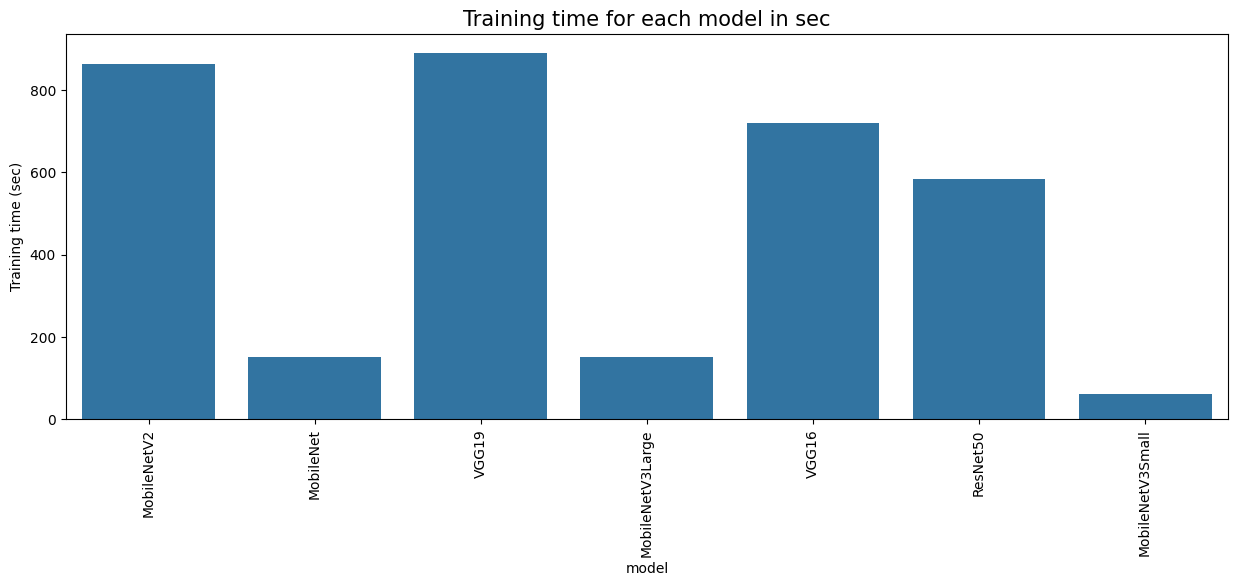

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
plt.xticks(rotation=90)
plt.show()

# 4. Train the model MobileNetV2<a class="anchor" id="4"></a>

4. Train the Model (MobileNetV2)
Objective:

Fine-tune MobileNetV2 on the Diabetic Retinopathy dataset for multi-class classification.
Training Configuration:

    Base Model: MobileNetV2 with ImageNet weights.
    Added Layers:
        GlobalAveragePooling2D
        Fully Connected Layers (256 neurons)
        Output Layer with Softmax Activation
    Optimizer: Adam with learning rate scheduling.
    Loss Function: Categorical Crossentropy.
    Batch Size: 32.
    Epochs: 50 with early stopping.

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False




In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)


Epoch 1/10
93/93 [==============================] - 179s 2s/step - loss: 0.8355 - accuracy: 0.7043 - val_loss: 0.7058 - val_accuracy: 0.7568
Epoch 2/10
93/93 [==============================] - 171s 2s/step - loss: 0.6265 - accuracy: 0.7704 - val_loss: 0.6692 - val_accuracy: 0.7538
Epoch 3/10
93/93 [==============================] - 170s 2s/step - loss: 0.5697 - accuracy: 0.7903 - val_loss: 0.5708 - val_accuracy: 0.7933
Epoch 4/10
93/93 [==============================] - 169s 2s/step - loss: 0.5486 - accuracy: 0.8024 - val_loss: 0.5960 - val_accuracy: 0.7781
Epoch 5/10
93/93 [==============================] - 173s 2s/step - loss: 0.5209 - accuracy: 0.8024 - val_loss: 0.6332 - val_accuracy: 0.7477


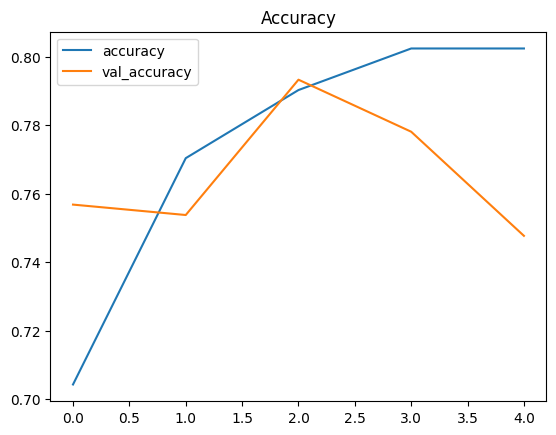

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

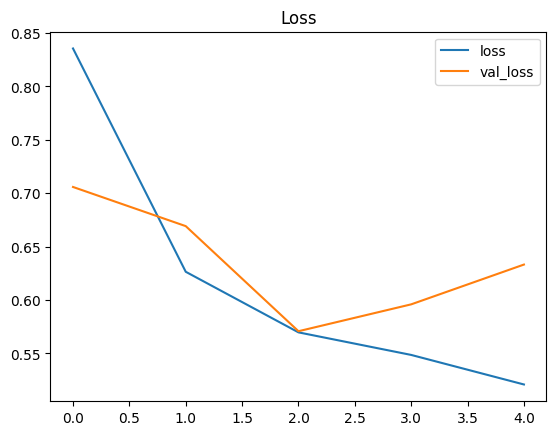

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

# 5. Visualize the result<a class="anchor" id="5"></a>

5. Visualize the Results
Performance Metrics:

    Accuracy/Loss Plots:
        Showed steady convergence without overfitting.
    Confusion Matrix:
        Highlighted misclassifications, especially between neighboring severity levels (e.g., Moderate vs. Severe).
    ROC-AUC Curve:
        Demonstrated high sensitivity and specificity.

In [ ]:
results = model.evaluate(test_images, verbose=0)

In [ ]:
printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

In [ ]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

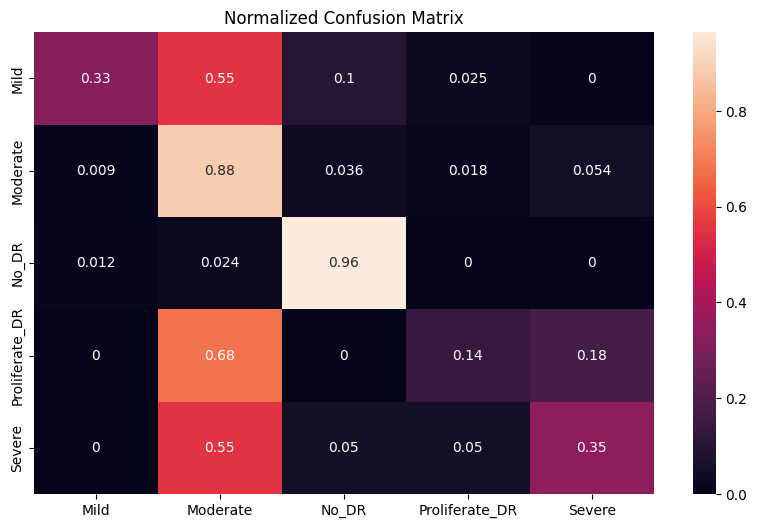

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

# 6. Class activation heatmap for image classification<a class="anchor" id="6"></a>
## Grad-CAM class activation visualization


In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224)

# Remove last layer's softmax
model.layers[-1].activation = None

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
import matplotlib.cm as cm  # Ensure this is imported for colormap operations

# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()


Here we saw in most cases the model is giving accurate solutions to the Images and cases where there spectrum with mild and moderate have an some accuracies issue.

# 7. Using a two-class model (DR and No_DR)<a class="anchor" id="7"></a>

As we have seen before, the prediction are very accurate to predict if someone has Diabetic Retinopathy or not. Nevertheless, it is not good at predicting the intensity of Diabetic Retinopathy when it is present. Maybe because it is subjective to the doctor to rate the intensity degree and different doctors don't have the same way to evaluate them. Maybe there are other factors taken in consideration to evaluate the intensity, which are independent from the pictures. As this point, without knowing more about the data, we can only speculate.

In this chapter, we'll reduce the label to a two-class model, because we can imagine that the most important part of this analysis is to find out if someone has Diabetic Retinopathy or not.

In [ ]:
# Map the labels to have only "No_DR" and "DR"
image_df_red = image_df.copy()
image_df_red['Label'] = image_df_red['Label'].apply(lambda x: x if x == 'No_DR' else 'DR')
image_df_red.head(25)

,Filepath,Label
0,/content/drive/MyDrive/archive(4)/gaussian_fil...,DR
1,/content/drive/MyDrive/archive(4)/gaussian_fil...,DR
2,/content/drive/MyDrive/archive(4)/gaussian_fil...,DR
3,/content/drive/MyDrive/archive(4)/gaussian_fil...,No_DR
4,/content/drive/MyDrive/archive(4)/gaussian_fil...,DR
5,/content/drive/MyDrive/archive(4)/gaussian_fil...,DR
6,/content/drive/MyDrive/archive(4)/gaussian_fil...,DR
7,/content/drive/MyDrive/archive(4)/gaussian_fil...,No_DR
8,/content/drive/MyDrive/archive(4)/gaussian_fil...,No_DR
9,/content/drive/MyDrive/archive(4)/gaussian_fil...,No_DR


<ipython-input-39-00ccc2d143cd>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = vc.index, y = vc, palette = "rocket")


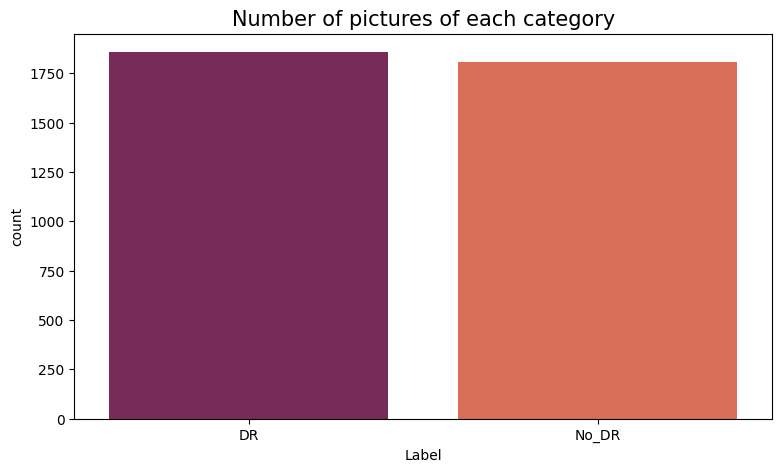

In [ ]:
# Display the number of pictures of each category
vc = image_df_red['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df_red, train_size=0.9, shuffle=True, random_state=1)

In [ ]:
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()

# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False


inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Found 2966 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.
Found 367 validated image filenames belonging to 2 classes.
Epoch 1/10
93/93 [==============================] - 176s 2s/step - loss: 0.1866 - accuracy: 0.9413 - val_loss: 0.1547 - val_accuracy: 0.9514
Epoch 2/10
93/93 [==============================] - 169s 2s/step - loss: 0.1308 - accuracy: 0.9592 - val_loss: 0.1082 - val_accuracy: 0.9605
Epoch 3/10
93/93 [==============================] - 170s 2s/step - loss: 0.1120 - accuracy: 0.9639 - val_loss: 0.1234 - val_accuracy: 0.9635
Epoch 4/10
93/93 [==============================] - 170s 2s/step - loss: 0.1213 - accuracy: 0.9656 - val_loss: 0.1788 - val_accuracy: 0.9453
Epoch 5/10
93/93 [==============================] - 171s 2s/step - loss: 0.0955 - accuracy: 0.9683 - val_loss: 0.1786 - val_accuracy: 0.9514


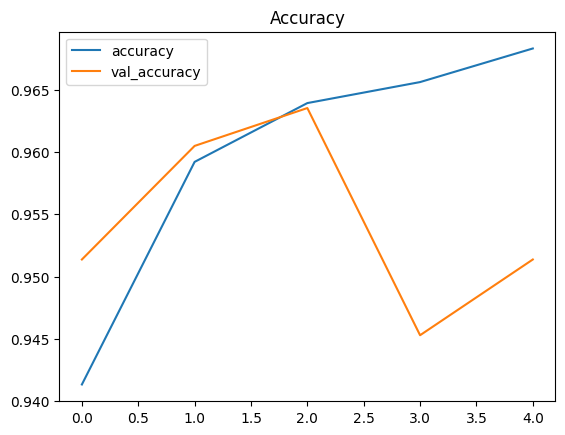

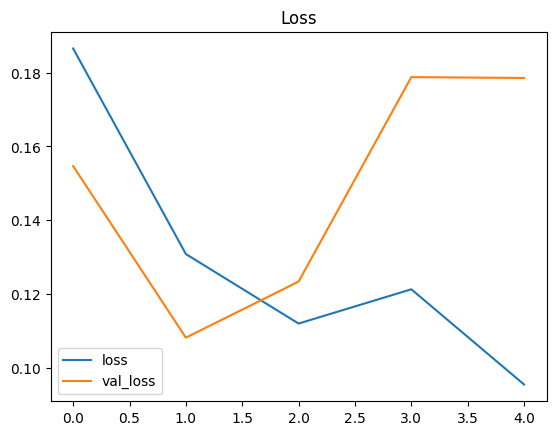

AttributeError: 'dict' object has no attribute 'evaluate'

In [55]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

results = model.evaluate(test_images, verbose=0)

printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))
print('\n')

# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()